In [1]:
import os
import glob
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from scipy import signal
from scipy.fft import fft, fftfreq


import sys
sys.path.insert(0,'..')


from clim_functions.mean_lat_weighted import mean_lat_weighted
from clim_functions.deseasonalize import deseasonalize


In [2]:
# Select run to plot
run = '038'
basedir = os.environ['SCRATCH']+'/MiMA/runs/'
rundir = basedir + run + '/'
print(rundir)

print(glob.glob(rundir+'*.nc'))
filename = 'atmos_daily'
dataset = nc.Dataset(rundir+filename+'.nc', 'r')

lon = dataset['lon']
lat = dataset['lat']
time = dataset['time']
pfull = dataset['pfull']
ucomp = dataset['ucomp']

/scratch/users/lauraman/MiMA/runs/038/
['/scratch/users/lauraman/MiMA/runs/038/atmos_daily.nc', '/scratch/users/lauraman/MiMA/runs/038/atmos_avg.nc']


## QBO plots

<Figure size 432x288 with 0 Axes>

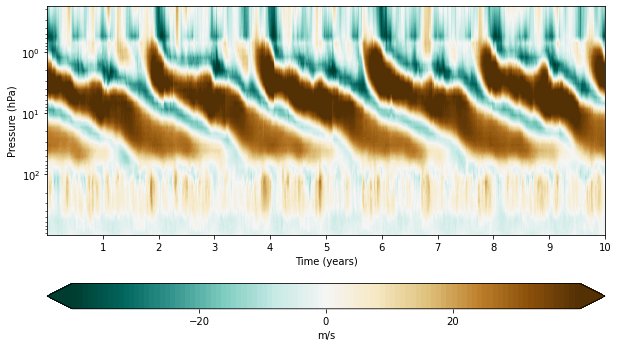

In [3]:
# Plot contours of zonal mean wind speeds in 4degS-4degN region (inds 30-34)
u_zonal = mean_lat_weighted( ucomp[:, :, 30:34, :].mean(axis=(-1)), lat[30:34], axis=(-1) )
t = time[:]

nrows = 1
ncols = 1

levels = np.linspace(-40, 40, 100)


plt.clf()
fig, axs = plt.subplots(nrows, ncols,figsize=(10, 6), gridspec_kw = {'wspace':0., 'hspace':0.}, sharey=True)

plt.contourf(time[:]-time[0], pfull[:], u_zonal.T, 
             cmap = 'BrBG_r', levels = levels, extend='both')
plt.ylabel('Pressure (hPa)')
plt.xlabel('Time (years)')
plt.xticks(np.arange(360., len(time)+1, 360.), np.arange(1, int((len(time)+1)/360)+1 , 1))
axs.set_yscale('log')
axs.invert_yaxis()
cbar = plt.colorbar(ticks=np.arange(-20, 20.5, 20), location='bottom', label='m/s',
                    orientation='horizontal')

In [4]:
u_deseason = deseasonalize(u_zonal, t)

<Figure size 432x288 with 0 Axes>

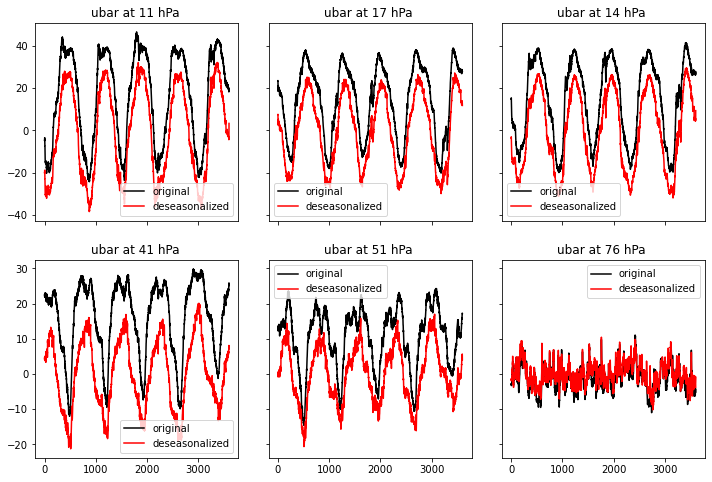

In [5]:
# Plot wind speeds at a few different heights in stratosphere
height_inds = [13, 15, 14, 19, 20, 22]
plt.clf()
fig, axs = plt.subplots(2, 3, figsize=(12, 8), 
                        gridspec_kw = {'wspace':0.15, 'hspace':0.2}, 
                        sharey='row', sharex=True)
axs = axs.flatten()
for i in range(len(height_inds)):
    height_ind = height_inds[i]
    plt.sca(axs[i])
    plt.plot(u_zonal[:, height_ind], color='black', label='original')
    plt.plot(u_deseason[:, height_ind], color='red', label='deseasonalized')
    plt.legend()
    plt.title('ubar at {:.2g} hPa '.format(pfull[height_ind]))

## Get QBO metrics: amplitude and period
We can test a few of different ways to calculate the period and amplitudes

In [3]:
from QBO_metrics.get_QBO_amplitude_DD import get_QBO_amplitude_DD
from QBO_metrics.get_QBO_period_FFT import get_QBO_period_FFT
from QBO_metrics.get_QBO_TT_metrics import get_QBO_TT

In [4]:
# Metrics are defined in stratosphere, pressure levels 50-10hPa (indices 13-20)
# First, we select the 4degS-4degN region and take zonal means 
strat = list(range(13, 20))
p_strat = pfull[strat]
u_zonal_strat = mean_lat_weighted( ucomp[:, strat, 30:34, :].mean(axis=(-1)), lat[30:34], axis=(-1) )
t = time[:]

### Dunkerton and Delisi method for calculating amplitude
This method first deseasonalizes the data, then filters out high variability, then calculates the standard devation. This can be calculated at multiple height levels.

In [5]:
amplitudes_DD = get_QBO_amplitude_DD(u_zonal_strat)
amplitudes_DD


array([29.23375505, 24.7447175 , 22.00627077, 20.68227145, 18.46236193,
       15.68495655, 13.51167781])

### FFT method for calculating period
This method uses an FFT to find the maximum peak in the spectrum. The data is first padded with zeros on either side to increase spectral resolution, we do not need to remove high variability as this will not be the maximum peak of the spectrum. This can be calculated at multiple height levels.

In [6]:
u_deseason_strat = deseasonalize(u_zonal_strat, time[:])
periods_FFT = get_QBO_period_FFT(u_zonal_strat)
periods_dFFT = get_QBO_period_FFT(u_deseason_strat)


In [7]:
periods_dFFT, periods_FFT

(array([24., 24., 24., 24., 24., 24., 24.]),
 array([24., 24., 24., 24., 24., 24., 24.]))

### Transition time method
This calculates the time between eastward-westward transitions in the original dataset (no deseasonalizing)
after smoothing witha 5 month running mean. This can be calculated at multiple height levels, but needs to be done independently.

In [8]:
period_and_amplitude_TT = np.array([(get_QBO_TT(u_zonal_strat[:,i], return_amplitude=True)) 
                                    for i in range(u_zonal_strat.shape[1]) ])

periods_TT = period_and_amplitude_TT[:,0]
amplitudes_TT = period_and_amplitude_TT[:,1]


QBO transition times: [182, 965, 1606, 2357, 3137]
QBO transition times: [252, 1016, 1674, 2432, 3202]
QBO transition times: [315, 1076, 1746, 2492, 3290]
QBO transition times: [377, 1151, 1830, 2551, 3337]
QBO transition times: [426, 1184, 1883, 2602, 3350]
QBO transition times: [467, 1199, 1897, 2635]
QBO transition times: [515, 1222, 1929, 2673]


In [9]:
amplitudes_TT

array([27.2496953 , 24.4753356 , 23.01613951, 20.74403381, 18.140378  ,
       15.70735486, 13.58420054])

In [10]:
## Check plots

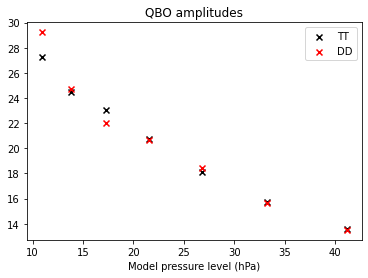

In [12]:
plt.scatter(p_strat, amplitudes_TT, label='TT', marker='x', color='k')
plt.scatter(p_strat, amplitudes_DD, label='DD', marker='x', color='r')
plt.xlabel('Model pressure level (hPa)')
plt.title('QBO amplitudes')
plt.legend()


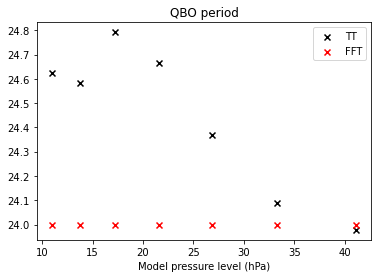

In [14]:
plt.title('QBO period')
plt.scatter(p_strat, periods_TT, label='TT', marker='x', color='k')
plt.scatter(p_strat, periods_FFT, label='FFT', marker='x', color='r')
plt.xlabel('Model pressure level (hPa)')
plt.legend()
